<a href="https://colab.research.google.com/github/sebac820/tarea-1-recsys/blob/main/Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1

## Librerías

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Actividad 1: Análisis exploratorio

Importamos y visualizamos los datos de entrenamiento:

In [5]:
train_set = pd.read_csv('transactions_train.csv', header=0, index_col=0)
print(f'El dataset de entrenamiento cuenta con {train_set.shape[0]} filas y {train_set.shape[1]} columnas.')
print('Las primeras cinco filas son:')
train_set.head()

El dataset de entrenamiento cuenta con 1318501 filas y 5 columnas.
Las primeras cinco filas son:


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2


### Número de compras por usuario

Obtenemos a los 10 usuarios más activos en el dataset:

In [6]:
# Hacemos una copia del set de entrenamiento manteniendo solamente la columna 'customer_id':
numero_de_compras_por_usuario = train_set.drop(columns=['t_dat', 'article_id', 'price', 'sales_channel_id'])
# Agregamos una columna 'numero_de_compras':
numero_de_compras_por_usuario['numero_de_compras'] = 1
# Agrupamos por 'customer_id' y contamos la cantidad de veces que se repite cada usuario en el set:
numero_de_compras_por_usuario = numero_de_compras_por_usuario.groupby('customer_id').count()
# Ordenamos la cuenta de cada usuario de mayor a menor:
numero_de_compras_por_usuario = numero_de_compras_por_usuario.sort_values(by='numero_de_compras', ascending=False)
# Calculamos el porcentaje que representa cada número de compras dentro del dataset:
numero_de_compras_por_usuario['porcentaje_del_dataset'] = numero_de_compras_por_usuario / train_set.shape[0] * 100
# Desplegamos el porcentaje total que representa el top 10 dentro del dataset:
porcentaje_total_que_representa_el_top_10 = numero_de_compras_por_usuario.iloc[0:10].sum()['porcentaje_del_dataset']
print(f'Porcentaje total que representa el top 10 dentro del dataset: {porcentaje_total_que_representa_el_top_10}%')
# Desplegamos el top 10 de usuarios más activos en el set:
display(numero_de_compras_por_usuario.head(10))

Porcentaje total que representa el top 10 dentro del dataset: 0.6309437763035446%


,numero_de_compras,porcentaje_del_dataset
customer_id,,
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc,1346,0.102086
84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb050070369176905712,950,0.072052
e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c72774e3f3338cbbb3335e,910,0.069018
2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8b56e5b66c86182bedf,875,0.066363
9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23704f1f654784bcda58,789,0.059841
bbebb44478948f5052c3f4c5dc04f08653e7938886a85685917fd22b92f22cd0,740,0.056124
d3b5f70ec21ad1718cf4951445e97007de0d4e85c39ea9fd2fedaf1966280943,724,0.054911
ad3090d52d11671ffb43bfaa85e3620eff669e8c92c9114ba7755876254cbba8,670,0.050815
0152d53f51444891ea07013fd1fb8325415bb09bb6798a59359b21a8326d801b,664,0.050360


Así, el top 10 de usuarios con más actividad en el dataset se lleva el 0.6% de las compras, reportando más de 600 compras cada uno. Sin embargo, el resto de usuarios ha realizado una cantidad mucho menor de compras:

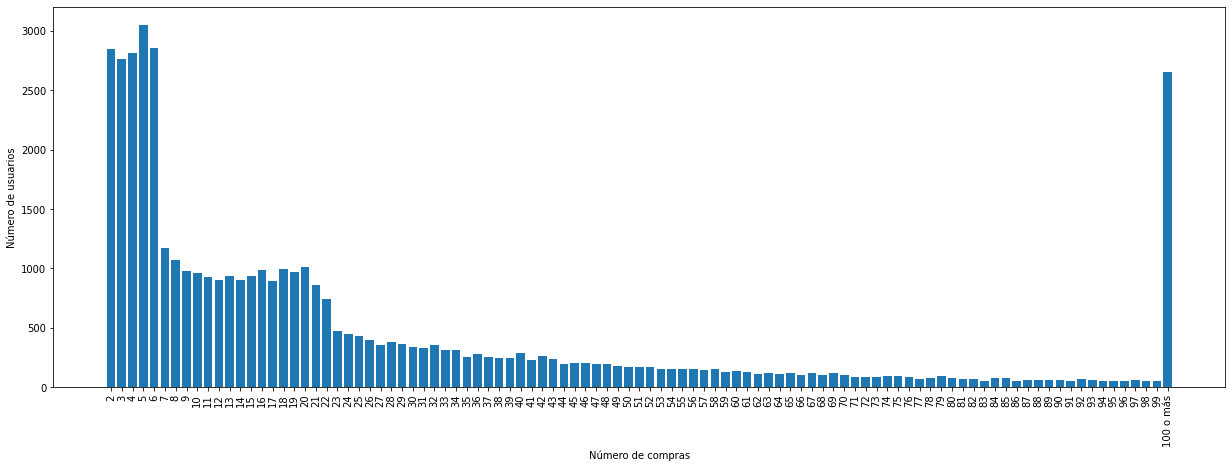

In [37]:
# Hacemos una copia del número de compras por usuario:
numero_de_usuarios_por_numero_de_compras = numero_de_compras_por_usuario.drop(columns=['porcentaje_del_dataset'])
# Agregamos una columna 'numero_de_usuarios':
numero_de_usuarios_por_numero_de_compras['numero_de_usuarios'] = 1
# Agrupamos por el número de compras, y contamos cuántos usuarios realizaron ese número de compras:
numero_de_usuarios_por_numero_de_compras = numero_de_usuarios_por_numero_de_compras.groupby('numero_de_compras').sum()
# Definimos un grupo que represente N o más compras:
N = 100
numero_de_usuarios_que_realizaron_N_o_mas_compras = numero_de_usuarios_por_numero_de_compras.loc[N:]['numero_de_usuarios'].sum()
numero_de_usuarios_por_numero_de_compras = numero_de_usuarios_por_numero_de_compras.loc[0:N-1]
numero_de_usuarios_por_numero_de_compras.loc[f'{N} o más'] = numero_de_usuarios_que_realizaron_N_o_mas_compras
# Graficamos:
plt.figure(figsize=(21, 7))
plt.xticks(rotation=90)
plt.bar(
    x=[i for i in range(len(numero_de_usuarios_por_numero_de_compras))],
    height=[numero_de_usuarios for numero_de_usuarios in numero_de_usuarios_por_numero_de_compras['numero_de_usuarios']],
    tick_label=numero_de_usuarios_por_numero_de_compras.index,
)
plt.xlabel('Número de compras')
plt.ylabel('Número de usuarios')
plt.show()

Notamos que en la distribución obtenida, la mayor parte de los usuarios han realizado solamente entre 2 a 6 compras, tras lo cual el número de usuarios que ha realizado un mayor número de compras decae rápidamente.

### Interacciones por producto

Cargamos los datos de los productos:

In [33]:
items = pd.read_csv('articles.csv', header=0, index_col=0)

Obtenemos los 10 productos más comprados:

In [34]:
# Hacemos una copia del train set, dejando solamente 'article_id':
compras_por_producto = train_set.drop(columns=['t_dat', 'customer_id', 'price', 'sales_channel_id'])
# Agregamos una columna 'compras':
compras_por_producto['compras'] = 1
# Agrupamos por producto y contamos cuántas veces fue comprado cada uno:
compras_por_producto = compras_por_producto.groupby('article_id', as_index=False).sum().sort_values(by='compras', ascending=False).merge(items, on='article_id')
# Agregamos el porcentaje de las interacciones que representa cada producto:
compras_por_producto['porcentaje_de_interacciones'] = compras_por_producto['compras'] * 100 / train_set.shape[0]
# Calculamos el porcentaje de interacciones del top 10 de productos:
print(f'Los 10 productos más comprados representan el {compras_por_producto["porcentaje_de_interacciones"].head(10).sum()}% de las interacciones en el dataset.')
# Desplegamos los 10 productos más comprados:
compras_por_producto[['article_id', 'prod_name', 'compras', 'porcentaje_de_interacciones']].head(10)


Los 10 productos más comprados representan el 0.8631013552511528% de las interacciones en el dataset.


,article_id,prod_name,compras,porcentaje_de_interacciones
0,706016001,Jade HW Skinny Denim TRS,1978,0.150019
1,706016002,Jade HW Skinny Denim TRS,1357,0.102920
2,610776002,Tilly (1),1302,0.098749
3,372860001,7p Basic Shaftless,1225,0.092909
4,759871002,Tilda tank,1010,0.076602
5,399223001,Curvy Jeggings HW Ankle,991,0.075161
6,464297007,Greta Thong Mynta Low 3p,920,0.069776
7,562245001,Luna skinny RW,899,0.068183
8,562245046,Luna skinny RW,849,0.064391
9,372860002,7p Basic Shaftless,849,0.064391


Así, el top 10 de productos más comprados representan el 0.8% del total de interacciones en el dataset. La distribución de interacciones se observa de la siguiente manera:

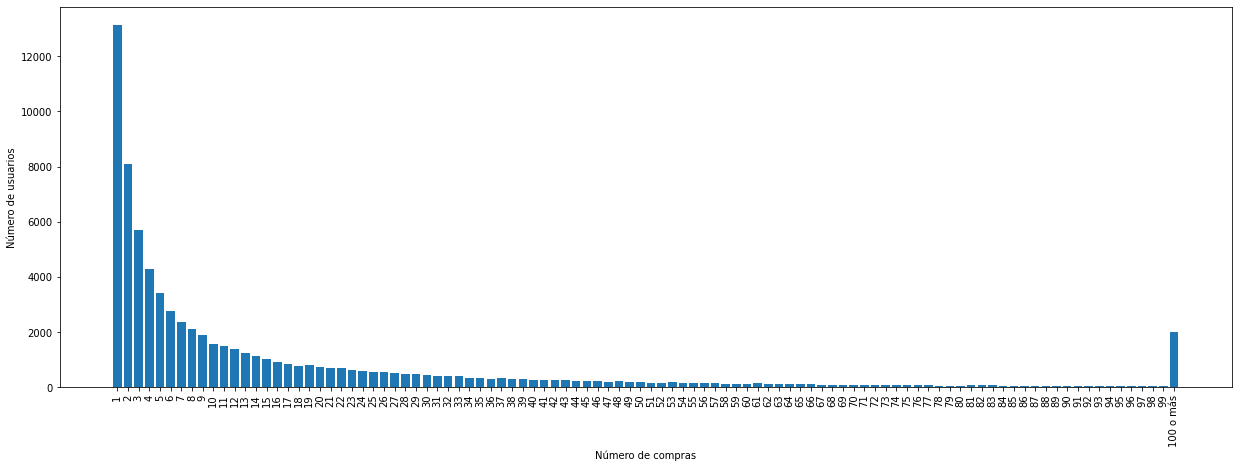

In [62]:
# Agregamos la columna 'numero_de_productos':
productos_por_compras = compras_por_producto[['compras']].copy()
productos_por_compras['numero_de_productos'] = 1
# Agrupamos por número de compras y contamos:
productos_por_compras = productos_por_compras.groupby('compras').sum()
# Definimos un grupo que represente N o más compras:
N = 100
productos_que_fueron_comprados_N_o_mas_veces = productos_por_compras.loc[N:]['numero_de_productos'].sum()
productos_por_compras = productos_por_compras.loc[0:N-1]
productos_por_compras.loc[f'{N} o más'] = productos_que_fueron_comprados_N_o_mas_veces
# Graficamos:
plt.figure(figsize=(21, 7))
plt.xticks(rotation=90)
plt.xlabel('Número de compras')
plt.ylabel('Número de productos')
plt.bar(
    x=[i for i in range(len(productos_por_compras))],
    height=[numero_de_productos for numero_de_productos in productos_por_compras['numero_de_productos']],
    tick_label=productos_por_compras.index,
)
plt.show()